Reference: https://qiita.com/everylittle/items/ba821e93d275a421ca2b  
  
RNN(LSTM) を試す、列の総和を出力するモデル  
可変長の場合、Embedding を使用する

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
import numpy as np
import random

In [3]:
input_dim = 1                # 入力データの次元数：実数値1個なので1を指定
output_dim = 1               # 出力データの次元数：同上
num_hidden_units = 128       # 隠れ層のユニット数
batch_size = 300             # ミニバッチサイズ
num_of_training_epochs = 100 # 学習エポック数
learning_rate = 0.001        # 学習率
num_training_samples = 1000  # 学習データのサンプル数

In [4]:
def create_data(nb_of_samples):
    # 長さを対数正規分布に従って決める
    leng = np.around(np.random.lognormal(np.log(5.0), 0.5, (nb_of_samples, 1))).astype("int")
    max_sequence_len = leng.max()

    # 乱数で {1, 2} の列を生成する
    X = np.random.randint(1, 3, (nb_of_samples, max_sequence_len))

    # 長さを超えた部分を0に置き換える
    X[np.arange(max_sequence_len).reshape((1, -1)) >= leng] = 0

    # 各行の2の個数を正解ラベルとする
    t = np.sum(X == 2, axis=1).astype("float32")

    # LSTM (Embedding) に与える入力は (サンプル, 時刻) の2次元になる。
    return X, t

In [5]:
random.seed(0)
np.random.seed(0)
#tf.set_random_seed(0)
tf.random.set_seed(0)

In [6]:
X, t = create_data(num_training_samples)

In [14]:
print(X.shape)
print(t.shape)

(1000, 20)
(1000,)


In [11]:
X[0]

array([1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
t[0]

7.0

In [15]:
#X.reshape(X.shape[:-1])

import pandas as pd
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,2,2,1,1,2,2,2,2,2,1,0,0,0,0,0,0,0,0
1,1,1,2,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,2,1,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,2,2,2,1,2,2,1,2,1,2,2,0,0,0,0,0
4,2,1,2,1,2,1,1,2,1,1,1,2,2,0,0,0,0,0,0,0


In [16]:
df2 = pd.concat([df, pd.Series(t, name='t')], axis=1)
df2.tail()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,t
995,2,1,2,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
996,2,2,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
997,1,1,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
998,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
999,1,2,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


In [17]:
# Embeddingの埋め込み行列を指定する
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embedding_matrix = np.array([[0.0], [0.0], [1.0]], dtype="float32")

In [18]:
print(embedding_matrix.shape)
print(embedding_matrix)

(3, 1)
[[0.]
 [0.]
 [1.]]


In [19]:
embedding = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=input_dim,
                      weights=[embedding_matrix],
                      trainable=False,
                      mask_zero=True)

embedding(X[0])

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [20]:
model = Sequential()

# Embeddingによりベクトルを変換する
model.add(Embedding(
    input_dim=embedding_matrix.shape[0], # 入力として取り得るカテゴリ数（パディングの0を含む）
    output_dim=input_dim,                # 出力ユニット数（本来の特徴量の次元数）
    weights=[embedding_matrix],          # 埋め込み行列を指定
    trainable=False,                     # 埋め込み行列を固定（学習時に更新しない）
    mask_zero=True))                     # 0をパディング用に特別扱いする

model.add(LSTM(num_hidden_units, return_sequences=False))

model.add(Dense(output_dim, activation="linear"))

model.compile(loss="mean_squared_error", optimizer=Adam(lr=learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 1)           3         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,692
Trainable params: 66,689
Non-trainable params: 3
_________________________________________________________________


In [21]:
hist = model.fit(X,
                 t,
                 batch_size=batch_size,
                 epochs=num_of_training_epochs,
                 validation_split=0.1)

Epoch 1/100
3/3 [==============================] - 1s 351ms/step - loss: 11.1452 - val_loss: 12.7703
Epoch 2/100
3/3 [==============================] - 0s 39ms/step - loss: 10.3005 - val_loss: 11.7463
Epoch 3/100
3/3 [==============================] - 0s 69ms/step - loss: 9.3723 - val_loss: 10.4806
Epoch 4/100
3/3 [==============================] - 0s 39ms/step - loss: 8.2014 - val_loss: 8.6512
Epoch 5/100
3/3 [==============================] - 0s 37ms/step - loss: 6.4625 - val_loss: 5.6953
Epoch 6/100
3/3 [==============================] - 0s 37ms/step - loss: 4.0564 - val_loss: 2.6165
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 1.9829 - val_loss: 1.7083
Epoch 8/100
3/3 [==============================] - 0s 38ms/step - loss: 1.7059 - val_loss: 2.4110
Epoch 9/100
3/3 [==============================] - 0s 38ms/step - loss: 1.8844 - val_loss: 2.3035
Epoch 10/100
3/3 [==============================] - 0s 38ms/step - loss: 1.5913 - val_loss: 1.7907
Epoch 11/100


Epoch 84/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0610 - val_loss: 0.0667
Epoch 85/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0597 - val_loss: 0.0647
Epoch 86/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0587 - val_loss: 0.0648
Epoch 87/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0573 - val_loss: 0.0621
Epoch 88/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0563 - val_loss: 0.0635
Epoch 89/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 90/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0543 - val_loss: 0.0620
Epoch 91/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0535 - val_loss: 0.0567
Epoch 92/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0531 - val_loss: 0.0550
Epoch 93/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0522 - val_loss: 0.0608
Epoch 94/1

<AxesSubplot:>

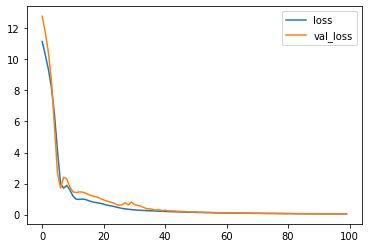

In [22]:
import pandas as pd

results = pd.DataFrame(hist.history)
results[['loss', 'val_loss']].plot()

In [23]:
# 任意の長さの入力を受け付ける
test = np.array([1, 1, 1, 0, 1, 0, 1])

In [24]:
(test + 1)

array([2, 2, 2, 1, 2, 1, 2])

In [25]:
(test + 1).reshape((1, -1))

array([[2, 2, 2, 1, 2, 1, 2]])

In [26]:
# {0, 1}を{1, 2}に変換してモデルに入力
# (a) 長さを変えずに入力
print(model.predict((test + 1).reshape((1, -1))))                              # [[4.88129]]

# (b) 後ろに適当な数の0を追加して入力
print(model.predict(np.pad((test + 1), (0, 10), "constant").reshape((1, -1)))) # [[4.88129]]

[[4.9335546]]
[[4.9335546]]
